In [1]:
import torch
import torch.nn as nn
import numpy as np

# AutoGrad：自動微分
`.requires_grad`属性が`True`に設定された場合、すべての操作が追跡される<br>
各Tensorは、そのTensorを作成した`Function`を参照する`.grad_fn`属性を持つ<br>
演算終了時には`.backward()`を呼び出すことで、すべての操作に対する勾配が自動的に計算される<br>
Tensorに対する勾配は`.grad`属性に蓄積されている<br>
追跡を停止する場合は、`.detach()`を呼び出すことで、その後の演算でこのTensorは追跡されなくなる<br>

## 誤差逆伝搬
各関数の層ごとで伝搬していけば、各値を求めることができる

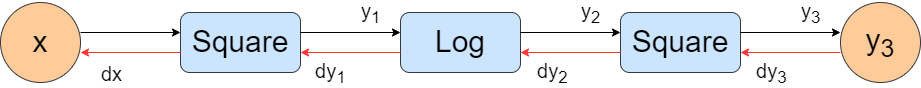
黒線：順伝搬<br>
<span style = "color: red;">赤線</span>：逆伝搬

In [2]:
class Square:
    def forward(self, x):
        self.x = x
        return self.x**2
    
    def backward(self, dy):
        return dy * (2 * self.x)

In [3]:
class Log:    
    def forward(self, x):
        self.x = x
        return np.log(x)
    
    def backward(self, dy):
        return dy * (1 / self.x)

In [4]:
square1 = Square()
log = Log()
square2 = Square()

### 順伝搬
$y_1 = x^2$<br>
$y_2 = \log{y_1}$<br>
$y_3 = y_2^2 = (\log{x^2})^2$<br>

In [5]:
x = 2

y1 = square1.forward(x)
y2 = log.forward(y1)
y3 = square2.forward(y2)
print("y1 : %f\ny2 : %f\ny3 : %f" % (y1, y2, y3))

y1 : 4.000000
y2 : 1.386294
y3 : 1.921812


### 逆伝搬
$\frac{d y_3}{d y_2} = 2 y_2$<br>
$\frac{d y_3}{d y_1} = \frac{d y_3}{d y_2}\frac{d y_2}{d y_1} = 2 y_2\cdot \frac{1}{y_1} $<br>
$\frac{d y_3}{d x} = \frac{d y_3}{d y_2}\frac{d y_2}{d y_1}\frac{d y_1}{d x} = 2 y_2 \cdot \frac{1}{y_1} \cdot 2 x$

In [6]:
dy2 = square2.backward(1)
dy1 = log.backward(dy2)
dx  = square1.backward(dy1)
print("dy2 : %f\ndy1 : %f\ndx  : %f\n" % (dy2, dy1, dx))

dy2 : 2.772589
dy1 : 0.693147
dx  : 2.772589



## 自動微分を用いた誤差逆伝搬 (1)
$y = w x + b$<br>
$w.grad = \frac{\partial y}{\partial w}
= \frac{\partial (w x + b)}{\partial w}
= \frac{\partial w x}{\partial w} + \frac{\partial b}{\partial w}
= x + 0
= x$<br>
$b.grad = \frac{\partial y}{\partial b}
= \frac{\partial (w x + b)}{\partial b}
= \frac{\partial w x}{\partial b} + \frac{\partial b}{\partial b}
= 0 + 1
= 1$<br>
`.grad`が表す値は、対象の微分変数が1変化した際、どの程度yが変化するかを表している

In [7]:
# 微分の変数として扱う場合は、requires_gradフラグをTrueにする
x = torch.tensor(10)
w = torch.tensor(3, requires_grad = True, dtype = torch.float64)
b = torch.tensor(5, requires_grad = True, dtype = torch.float64)

y = w * x + b
print(y) # 計算履歴としてgrad_fn属性を持っており、どのような計算が行われたか確認できる

y.backward()
print(f"w.grad : {w.grad.item()}")
print(f"b.grad : {b.grad.item()}")

tensor(35., dtype=torch.float64, grad_fn=<AddBackward0>)
w.grad : 10.0
b.grad : 1.0


### ライブラリ使用
`nn.Linear(in_features, out_features, bias, device=None, dtype=None)`
- `in_features`  : 各入力サンプルのサイズ 
- `out_features` : 各出力サンプルのサイズ
- `bias`         : Falseにするとバイアスを設定しない、デフォルトではTrue

In [8]:
x = torch.tensor([10]).unsqueeze(1).float()

linear = nn.Linear(1, 1) # 入力と出力が1次元
y = linear(x)

y.backward()
print(f"w.grad : {linear.weight.grad.item()}")
print(f"b.grad : {linear.bias.grad.item()}")

w.grad : 10.0
b.grad : 1.0


## 自動微分を用いた誤差逆伝搬 (2)
$L = \frac{1}{N} \sum_{n} (y_n - t_n)^2$<br>
$w.grad = \frac{\partial L}{\partial w}
= \frac{\partial L}{\partial y} \frac{\partial y}{\partial w}
= \frac{1}{N} \cdot \sum_{n} (2(y_n - t_n) \cdot x_n)$<br>
$b.grad = \frac{\partial L}{\partial b}
= \frac{\partial L}{\partial y} \frac{\partial y}{\partial b}
= \frac{1}{N} \sum_{n} (2(y_n - t_n) \cdot 1)$

In [9]:
x = torch.tensor([10, 11, 12, 13, 14])
w = torch.tensor(3, requires_grad = True, dtype = torch.float64)
b = torch.tensor(5, requires_grad = True, dtype = torch.float64)
t = torch.tensor([32, 35, 38, 41, 44])

def MSE(y, t):
    sum = 0
    for (_y, _t) in zip(y, t):
        sum += (_y - _t)**2
    return sum / len(y)

y = w * x + b
L = MSE(y, t)

L.backward()
print(f"w.grad : {w.grad}")
print(f"b.grad : {b.grad}")

w.grad : 72.0
b.grad : 6.000000000000001


### ライブラリ使用
`nn.MSELoss(size_average=None, reduce=None, reduction="mean")`<br>
入力内の各要素間の平均二乗誤差（L2ノルム）を測定

In [10]:
x = torch.tensor([10, 11, 12, 13, 14]).unsqueeze(1).float()
t = torch.tensor([32, 35, 38, 41, 44]).unsqueeze(1).float()

linear = nn.Linear(1, 1)
linear.weight = nn.Parameter(torch.tensor([[3.0]]))
linear.bias = nn.Parameter(torch.tensor([[5.0]]))
MSE = nn.MSELoss()

y = linear(x)
L = MSE(y, t)

L.backward()
print(f"w.grad : {linear.weight.grad.item()}")
print(f"b.grad : {linear.bias.grad.item()}")

w.grad : 72.00000762939453
b.grad : 6.0
